# Preamble

In [1]:
# Essentials
import os, sys, glob
import pandas as pd
import numpy as np
import nibabel as nib

# Stats
import scipy as sp
from scipy import stats
import statsmodels.api as sm
import pingouin as pg

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
sys.path.append('/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/code/func/')
from proj_environment import set_proj_env
sys.path.append('/Users/lindenmp/Dropbox/Work/git/pyfunc/')
from func import my_get_cmap

In [3]:
exclude_str = 't1Exclude'
_ = set_proj_env(exclude_str = exclude_str)

### Setup output directory

In [4]:
print(os.environ['TRTEDIR'])
if not os.path.exists(os.environ['TRTEDIR']): os.makedirs(os.environ['TRTEDIR'])

/Users/lindenmp/Dropbox/Work/ResProjects/neurodev_cs_predictive/analysis/t1Exclude/squeakycleanExclude


# Load in metadata

In [5]:
# LTN and Health Status
health = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/health/n1601_health_20170421.csv'))
# Protocol
prot = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/n1601_pnc_protocol_validation_params_status_20161220.csv'))
# T1 QA
t1_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_t1QaData_20170306.csv'))
# DTI QA
dti_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/dti/n1601_dti_qa_20170301.csv'))
# Rest QA
rest_qa = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/rest/n1601_RestQAData_20170714.csv'))
# Demographics
demog = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/demographics/n1601_demographics_go1_20161212.csv'))
# Brain volume
brain_vol = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/neuroimaging/t1struct/n1601_ctVol20170412.csv'))

# GOASSESS Bifactor scores
goassess = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'GO1_clinical_factor_scores_psychosis_split_BIFACTOR.csv'))
# cnb
cnb = pd.read_csv(os.path.join(os.environ['DERIVSDIR'], 'pncDataFreeze20170905/n1601_dataFreeze/cnb/n1601_cnb_factor_scores_tymoore_20151006.csv'))

# merge
df = health
df = pd.merge(df, prot, on=['scanid', 'bblid']) # prot
df = pd.merge(df, t1_qa, on=['scanid', 'bblid']) # t1_qa
df = pd.merge(df, dti_qa, on=['scanid', 'bblid']) # dti_qa
df = pd.merge(df, rest_qa, on=['scanid', 'bblid']) # rest_qa
df = pd.merge(df, demog, on=['scanid', 'bblid']) # demog
df = pd.merge(df, brain_vol, on=['scanid', 'bblid']) # brain_vol

df = pd.merge(df, goassess, on=['bblid']) # goassess
df = pd.merge(df, cnb, on=['scanid', 'bblid']) # brain_vol

print(df.shape[0])
df.set_index(['bblid', 'scanid'], inplace = True)

1599


In [6]:
df.head()

,,timepoint_x,smrytrt_psychinpt,psychoactiveMedPsychv2,psychoactiveMedMedicalv2,incidentalFindingExclude,medicalratingExcludev1,healthExcludev2,ltnExcludev2,squeakycleanExclude,psychoactiveMedMedical,...,F1_Exec_Comp_Cog_Accuracy_Ar,F2_Social_Cog_Accuracy_Ar,F3_Memory_Accuracy_Ar,F1_Social_Cognition_Efficiency_Ar,F2_Complex_Reasoning_Efficiency_Ar,F3_Memory_Efficiency_Ar,F4_Executive_Efficiency_Ar,F1_Slow_Speed_Ar,F2_Memory_Speed_Ar,F3_Fast_Speed_Ar
bblid,scanid,,,,,,,,,,,,,,,,,,,,,
80961,2632,1,0,1,0,0,0,0,1,1,0,...,-1.147680,-0.985732,0.103675,-0.248342,-1.500726,0.749361,0.276936,0.012737,0.673015,0.927039
80199,2637,1,0,0,0,0,0,0,0,0,0,...,-0.262102,0.951817,-0.729813,1.309180,0.323467,-0.216490,-0.439120,0.882288,0.621913,-0.233789
80179,2643,1,1,1,0,0,0,0,1,1,0,...,-2.456514,-3.463454,-2.023924,-2.082903,-0.919736,-0.722441,-1.598467,1.000161,0.009006,-0.118194
81005,2644,1,0,0,0,0,1,1,1,1,0,...,1.164884,1.348419,0.936387,0.899698,1.231159,1.485604,0.195561,-0.180368,1.025021,0.518658
80812,2646,1,0,0,0,0,0,0,0,1,0,...,0.454563,0.892760,0.400804,1.000376,1.442359,0.554244,0.390312,0.891195,0.657851,0.582442


# Filter subjects

In [7]:
# 1) Primary sample filter
df = df[df['healthExcludev2'] == 0]
print('N after initial exclusion:', df.shape[0])

# 2) T1 exclusion
df = df[df[exclude_str] == 0]
print('N after T1 exclusion:', df.shape[0])

# 3) Diffusion exclusion
df = df[df['b0ProtocolValidationStatus'] == 1]
df = df[df['dti64ProtocolValidationStatus'] == 1]
df = df[df['dti64Exclude'] == 0]
print('N after Diffusion exclusion:', df.shape[0])

N after initial exclusion: 1445
N after T1 exclusion: 1394
N after Diffusion exclusion: 1100


In [8]:
df['dti64QAManualScore'].unique()

array([2., 1.])

In [9]:
np.sum(df['dti64QAManualScore'] == 2)

675

# Randomly sample subset for nuisance regression

In [10]:
df.loc[:,'nuisance_sample'] = 0
np.random.seed(0)
my_idx = df.sample(frac = 0.1).index
df.loc[my_idx,'nuisance_sample'] = 1
print('Main sample: ', np.sum(df['nuisance_sample'] == 0), 'Nuisance sample:', np.sum(df['nuisance_sample'] == 1))

Main sample:  990 Nuisance sample: 110


# Characterise dataset

In [11]:
# Convert age to years
df['ageAtScan1_Years'] = np.round(df.ageAtScan1/12, decimals=1)

In [12]:
# find unique ages
age_unique = np.unique(df.ageAtScan1_Years)
print('There are', age_unique.shape[0], 'unique age points')

# Check if train and test represent the full unique age space
train_diff = np.setdiff1d(df[df['nuisance_sample'] == 0].ageAtScan1_Years,age_unique)
test_diff = np.setdiff1d(df[df['nuisance_sample'] == 1].ageAtScan1_Years,age_unique)

if train_diff.size == 0:
    print('All unique age points are represented in the main set')
elif train_diff.size != 0:
    print('All unique age points ARE NOT represented in the main set')
    
if test_diff.size == 0:
    print('All unique age points are represented in the nuisance set')
elif test_diff.size != 0:
    print('All unique age points ARE NOT represented in the nuisance set')

There are 144 unique age points
All unique age points are represented in the main set
All unique age points are represented in the nuisance set


## Export

In [13]:
header = ['nuisance_sample', 'ageAtScan1', 'ageAtScan1_Years','sex','race2','handednessv2',
          'dti64MeanAbsRMS','dti64MeanRelRMS','dti64MaxAbsRMS','dti64MaxRelRMS','mprage_antsCT_vol_TBV', 'averageManualRating',
          'Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear',
            'Overall_Efficiency', 'Overall_Accuracy',
           'Overall_Speed', 'F1_Exec_Comp_Res_Accuracy', 'F2_Social_Cog_Accuracy',
           'F3_Memory_Accuracy', 'F1_Complex_Reasoning_Efficiency',
           'F2_Memory.Efficiency', 'F3_Executive_Efficiency',
           'F4_Social_Cognition_Efficiency', 'F1_Slow_Speed', 'F2_Fast_Speed',
           'F3_Memory_Speed', 'Overall_Efficiency_Ar', 'Overall_Accuracy_Ar',
           'Overall_Speed_Ar', 'F1_Exec_Comp_Cog_Accuracy_Ar',
           'F2_Social_Cog_Accuracy_Ar', 'F3_Memory_Accuracy_Ar',
           'F1_Social_Cognition_Efficiency_Ar',
           'F2_Complex_Reasoning_Efficiency_Ar', 'F3_Memory_Efficiency_Ar',
           'F4_Executive_Efficiency_Ar', 'F1_Slow_Speed_Ar', 'F2_Memory_Speed_Ar',
           'F3_Fast_Speed_Ar']
df.to_csv(os.path.join(os.environ['TRTEDIR'], 'df_pheno.csv'), columns = header)

# Plots

In [14]:
if not os.path.exists(os.environ['FIGDIR']): os.makedirs(os.environ['FIGDIR'])
os.chdir(os.environ['FIGDIR'])
sns.set(style='white', context = 'paper', font_scale = 1)
cmap = my_get_cmap('pair')

labels = ['Train', 'Test']
phenos = ('Overall_Psychopathology','Psychosis_Positive','Psychosis_NegativeDisorg','AnxiousMisery','Externalizing','Fear')
phenos_label_short = ('Ov. Psych.', 'Psy. (pos.)', 'Psy. (neg.)', 'Anx.-mis.', 'Ext.', 'Fear')
phenos_label = ('Overall Psychopathology','Psychosis (Positive)','Psychosis (Negative)','Anxious-Misery','Externalizing','Fear')
print(phenos)

('Overall_Psychopathology', 'Psychosis_Positive', 'Psychosis_NegativeDisorg', 'AnxiousMisery', 'Externalizing', 'Fear')


## Age

In [15]:
df['sex'].unique()

array([2, 1])

In [16]:
np.sum(df.loc[df['nuisance_sample'] == 1,'sex'] == 2)

51

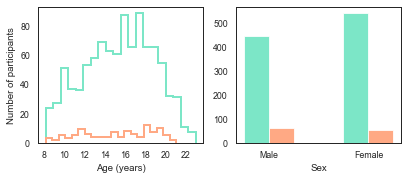

In [17]:
f, axes = plt.subplots(1,2)
f.set_figwidth(6.5)
f.set_figheight(2.5)
colormap = sns.color_palette("pastel", 2)

sns.distplot(df.loc[df['nuisance_sample'] == 0,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[0],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[0]), ax = axes[0]);
sns.distplot(df.loc[df['nuisance_sample'] == 1,'ageAtScan1_Years'], bins=20, hist=True, kde=False, rug=False, label = labels[1],
             hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1}, color=list(cmap[1]), ax = axes[0]);
axes[0].set_xlabel('Age (years)');
axes[0].set_ylabel('Number of participants');
axes[0].set_xticks(np.arange(np.min(np.round(age_unique,0)), np.max(np.round(age_unique,0)), 2))

# set width of bar
barWidth = 0.25

# Sex
y_train = [np.sum(df.loc[df['nuisance_sample'] == 0,'sex'] == 1), np.sum(df.loc[df['nuisance_sample'] == 0,'sex'] == 2)]
y_test = [np.sum(df.loc[df['nuisance_sample'] == 1,'sex'] == 1), np.sum(df.loc[df['nuisance_sample'] == 1,'sex'] == 2)]
r1 = np.arange(len(y_train))+barWidth/2
r2 = [x + barWidth for x in r1]
axes[1].bar(r1, y_train, width = barWidth, color = cmap[0], label = labels[0])
axes[1].bar(r2, y_test, width = barWidth, color = cmap[1], label = labels[1])
axes[1].set_xlabel('Sex')
# axes[1].set_ylabel('Number of participants')
axes[1].set_xticks([r + barWidth for r in range(len(y_train))])
axes[1].set_xticklabels(['Male', 'Female'])

f.savefig('age_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)

## Phenotype distributions over train/test

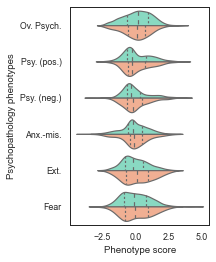

In [18]:
df_rc = pd.melt(df, id_vars = 'nuisance_sample', value_vars = phenos)

f, ax = plt.subplots()
f.set_figwidth(2.5)
f.set_figheight(4)
ax = sns.violinplot(y='variable', x='value', hue='nuisance_sample', data=df_rc, palette = cmap, split=True, scale='width', inner = 'quartile', orient = 'h')
ax.get_legend().remove()
ax.set_yticklabels(phenos_label_short)
ax.set_ylabel('Psychopathology phenotypes')
ax.set_xlabel('Phenotype score')
f.savefig('phenos_distributions.svg', dpi = 300, bbox_inches = 'tight', pad_inches = 0)